# Using a Temporal Convolutional Network for Daytrading
## Daniel Kalam, Sharvita Paithankar

In [436]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv1D, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
import pandas as pd
from pandas_datareader import DataReader
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Gathering Data
Getting data for 100 stocks in the date range of April 2nd, 2018 to October 9th, 2020 from yahoo finance.

In [437]:
symbols = ['AAPL', 'TSLA', 'FB', 'ROKU']# , 'BRK', 'GOOGL', 'INTC', 'AMD', 'HPE', 'ZM',
          #'CAKE', 'AET', 'F', 'KO', 'DDS', 'NVDA', 'NFLX', 'JPM', 'AMZN', 'MSFT']
#TODO: Add 80 more symbols.
source = 'yahoo'
start_date = pd.to_datetime('2019-10-09')
end_date = pd.to_datetime('2020-10-09')
stock_data_training = {}
for symbol in symbols:
    stock_data_training[symbol] = DataReader(symbol, source, start_date, end_date)
symbols2 = ['NFLX', 'ZM', 'AMZN', 'MSFT']
stock_data_validation = {}
for symbol in symbols2:
    stock_data_validation[symbol] = DataReader(symbol, source, start_date, end_date)

Create a data frame for each column in a stock's data frame.

In [438]:
stock_training_input = np.empty((20, 254, 1))
stock_training_output = np.zeros((20, 254, 2))
stock_validation_input = np.empty((20, 254, 1))
stock_validation_output = np.zeros((20, 254, 2))
i = 0
scaler = StandardScaler()
for symbol in stock_data_training:
    close_data = stock_data_training[symbol].Close
    open_data = stock_data_training[symbol].Open
    #stock_data[symbol].drop(axis= 1, columns = ['Close', 'High', 'Low', 'Volume', 'Adj Close'], inplace = True)
    stock_np = stock_data_training[symbol].Open.to_numpy().reshape(254, 1)
    stock_np = scaler.fit_transform(stock_np)
    #if stock_np.shape == stock_training_data_input[i].shape:
    stock_training_input[i, :, :] = stock_np[:, :]
    for j in range(0, len(close_data)):
        if close_data[j] > open_data[j]:
            stock_training_output[i, j, 0] = 1
            stock_training_output[i, j, 1] = 0
        else:
            stock_training_output[i, j, 0] = 0
            stock_training_output[i, j, 1] = 1
    i+=1
for symbol in stock_data_validation:
    close_data = stock_data_validation[symbol].Close
    open_data = stock_data_validation[symbol].Open
    #stock_data[symbol].drop(axis= 1, columns = ['Close', 'High', 'Low', 'Volume', 'Adj Close'], inplace = True)
    stock_np = stock_data_validation[symbol].Open.to_numpy().reshape(254, 1)
    stock_np = scaler.fit_transform(stock_np)
    #if stock_np.shape == stock_training_data_input[i].shape:
    stock_validation_input[i, :, :] = stock_np[:, :]
    for j in range(0, len(close_data)):
        if close_data[j] > open_data[j]:
            stock_validation_output[i, j, 0] = 1
            stock_validation_output[i, j, 1] = 0
        else:
            stock_validation_output[i, j, 0] = 0
            stock_validation_output[i, j, 1] = 1
    i+=1

## TensorFlow
### Converting the Data Into Tensors
Turn the data frames into tensorflow datatypes so that they can be processed by tensorflow.

In [439]:
delete = []
for j in range(i, 20):
    delete.append(j)
stock_training_input = np.delete(stock_training_input, delete, axis=0)
stock_training_output = np.delete(stock_training_output, delete, axis=0)

stock_validation_input = np.delete(stock_training_input, delete, axis=0)
stock_validation_output = np.delete(stock_training_output, delete, axis=0)

<ipython-input-439-dbceed9d368c>:7: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  stock_validation_input = np.delete(stock_training_input, delete, axis=0)
<ipython-input-439-dbceed9d368c>:8: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  stock_validation_output = np.delete(stock_training_output, delete, axis=0)


### Temporal Convolutional Network Class

In [440]:
filter_count = 2 # Amount of filters
final_filter_count = 2
filters = [] # Filter size for each residual block
kernel_size = 10 #Resolution of each filter
level = kernel_size
n = 0
while level <= 254:
    filters.append(filter_count)
    level+=kernel_size + (kernel_size-1)*2**n
    n+=1
filters[-1] = final_filter_count

In [441]:
class ResidualBlock(Layer):
    def __init__(self, filters, kernel_size, strides, dilation_rate, activation,
                trainable, dropout, dtype=None, activity_regularizer=None, **kwargs):
        super(ResidualBlock, self).__init__(trainable, dtype=dtype)
        self.activation = activation
        self.dropout = dropout
        self.filters = filters
        self.adjust_sample = None
        self.layer_norm = BatchNormalization(axis=-1)
        self.dilatedcausal1 = Conv1D(filters,
                                     kernel_size,
                                     strides,
                                     'causal',
                                     dilation_rate=dilation_rate)
        self.dilatedcausal2 = Conv1D(filters,
                                     kernel_size,
                                     strides,
                                     'causal',
                                     dilation_rate=dilation_rate)

    #Make the dropout based on the shape of the input
    def build(self, input_shape):
        self.drop1 = Dropout(self.dropout, input_shape)
        self.drop2 = Dropout(self.dropout, input_shape)
        print('INPUT SHAPE ')
        print(input_shape)
        print(filters)
        if input_shape[2]!=filters:
            print('IF EXECUTED')
            self.adjust_sample = Dense(self.filters)

    #The residual block processes the input
    def call(self, inputs, training):
        x = self.dilatedcausal1(inputs)
        x = self.layer_norm(x, training)
        x = self.activation(x)
        x = self.drop1(x, training) #If training is False, drop1 simply returns x
        x = self.dilatedcausal2(x)
        x = self.layer_norm(x, training)
        x = self.activation(x)
        x = self.drop2(x, training) #If training is False, drop2 simply returns x
        if self.adjust_sample is not None:
            inputs = self.adjust_sample(inputs)
        return self.activation(x+inputs)
        
class TCN(Model):
    def __init__(self, filters, kernel_size=2, dropout = 0.2, activation='relu',
                trainable=False, dtype=None, name=None,
                activity_regularizer=None, **kwargs):
        super(TCN, self).__init__()
        self.levels = []
        for i in range(0, len(filters)):
            self.levels.append(ResidualBlock(filters[i], kernel_size,
                                             1, 2**i, Activation(activation),
                                             trainable, dropout,
                                             dtype, activity_regularizer))
    
    #Running the input through each residual block
    def call(self, inputs, training=True):
        for r_block in self.levels:
            inputs = r_block(inputs, training)
        return inputs
stock_training_output[0].shape

(254, 2)

### Training the TCN

In [442]:
tcn_model = TCN(filters, kernel_size, activation='relu', trainable = True, dtype='float')
tcn_model.compile(optimizer='adam', loss = 'mse', metrics=['accuracy'])
tcn_model.fit(stock_training_input, stock_training_output, epochs = 120)

Epoch 1/120
INPUT SHAPE 
(None, 254, 1)
[2, 2, 2, 2, 2]
IF EXECUTED
INPUT SHAPE 
(None, 254, 2)
[2, 2, 2, 2, 2]
IF EXECUTED
INPUT SHAPE 
(None, 254, 2)
[2, 2, 2, 2, 2]
IF EXECUTED
INPUT SHAPE 
(None, 254, 2)
[2, 2, 2, 2, 2]
IF EXECUTED
INPUT SHAPE 
(None, 254, 2)
[2, 2, 2, 2, 2]
IF EXECUTED
1/1 [==============================] - 0s 0s/step - loss: 0.7943 - accuracy: 0.4719
Epoch 2/120
1/1 [==============================] - 0s 1ms/step - loss: 0.7753 - accuracy: 0.4306
Epoch 3/120
1/1 [==============================] - 0s 1ms/step - loss: 0.7878 - accuracy: 0.4498
Epoch 4/120
1/1 [==============================] - 0s 1ms/step - loss: 0.7680 - accuracy: 0.4296
Epoch 5/120
1/1 [==============================] - 0s 1ms/step - loss: 0.7521 - accuracy: 0.4473
Epoch 6/120
1/1 [==============================] - 0s 998us/step - loss: 0.8232 - accuracy: 0.4365
Epoch 7/120
1/1 [==============================] - 0s 1ms/step - loss: 0.6851 - accuracy: 0.4400
Epoch 8/120
1/1 [=======================

1/1 [==============================] - 0s 998us/step - loss: 0.2802 - accuracy: 0.4744
Epoch 82/120
1/1 [==============================] - 0s 996us/step - loss: 0.2698 - accuracy: 0.5030
Epoch 83/120
1/1 [==============================] - 0s 998us/step - loss: 0.2930 - accuracy: 0.4744
Epoch 84/120
1/1 [==============================] - 0s 998us/step - loss: 0.2849 - accuracy: 0.5054
Epoch 85/120
1/1 [==============================] - 0s 1ms/step - loss: 0.2712 - accuracy: 0.4970
Epoch 86/120
1/1 [==============================] - 0s 1ms/step - loss: 0.2874 - accuracy: 0.4926
Epoch 87/120
1/1 [==============================] - 0s 999us/step - loss: 0.2741 - accuracy: 0.5010
Epoch 88/120
1/1 [==============================] - 0s 1ms/step - loss: 0.2787 - accuracy: 0.4975
Epoch 89/120
1/1 [==============================] - 0s 1ms/step - loss: 0.2664 - accuracy: 0.4921
Epoch 90/120
1/1 [==============================] - 0s 1ms/step - loss: 0.2793 - accuracy: 0.4906
Epoch 91/120
1/1 [=====

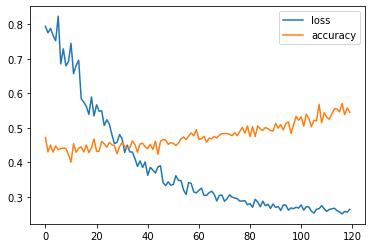

In [443]:
losses = pd.DataFrame(tcn_model.history.history)
losses.plot()

# Predictions

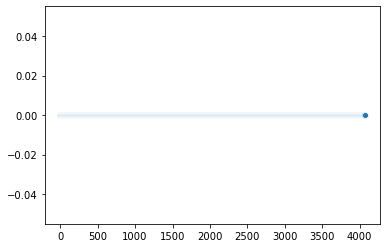

In [444]:
import seaborn as sns
test_predictions = tcn_model.predict(stock_training_input)

test_predictions = pd.Series(test_predictions.reshape(4064,))
# pred_df = pd.DataFrame(stock_training_output[0], columns=['Test True Y'])
sns.scatterplot(data=test_predictions)